A notebook for processing images acquired with the OROCHI simulator to reflectance, with coalignment by stereo geometric calibration.

# Overview

The steps of processing are:
1. Calibration Preparation:
    - Load, average and bias correct Calibration Target images
    - Correct for exposure
    - Load reference reflectance for each channel
    - Scale images to give reflectance calibration coefficient for each pixel
    - Optional: mask for Calibration Target
    - Save reflectance calibration images
2. Sample Reflectance Calibration
    - Load, average and bias correct Sample images
    - Correct for exposure
    - Apply calibration coefficient frames
    - Optional: mask for Calibration Target area and Sample area.
    - Save reflectance images
3. Geometric Alignment
    - Load, average and bias correct Geometric images
    - Balance images (TBD)
    - Extract camera geometric calibration coefficients (TBD)
    - Apply image coregistration (TBD)

# Functions

Here we define some classes and functions for hadnling the reading and processing of the images.

For these steps we require reusable function for loading a given image set into memory, and returning the average stack.

We also want to be able to store the information from the metadata of the images,
so it makes sene to define a simple new image class, that has properties of:

        'camera': camera['number'],
        'serial': camera['name'],
        'cwl': camera['cwl'],
        'fwhm': camera['fwhm'],
        'f-number': camera['fnumber'],
        'f-length': camera['flength'],
        'exposure': exposure,
        'target': target # e.g. calibration, meteorite name, office-test...S
        'units': units # count (DN), flux (DN/s), Reflectance (R), str
        'number of images': n_imgs # number of repeat images captured, int
        'image stack': img_arr # stack of n_imgs in np.array, int
        'image mean': img_ave # average of image stack, float
        'image error': img_std # standard deviation of image stack, float


In [1]:
class Image:
    def __init__(self, target: str, channel: str, img_type: str) -> None:
        """Initialise properties. Most of these are populated during image load.
        """
        self.dir = Path('..', 'data', target, channel)
        # TODO check target directory exists
        self.target = target
        self.channel = channel
        self.img_type = img_type
        self.camera = None
        self.serial = None
        self.width = None
        self.height = None
        self.cwl = None
        self.fwhm = None
        self.fnumber = None
        self.flength = None
        self.exposure = None
        self.units = ''
        self.n_imgs = None
        self.img_stk = None
        self.img_ave = None
        self.img_std = None
    
    def image_load(self):
        """Load images from the target directory for the given type, 
        populate properties, and compute averages and standard deviation.
        """        
        # get list of images of given type in the target directory
        files = list(self.dir.glob('*'+self.img_type+'.tif'))
        # set n_imgs
        self.n_imgs = len(files)
        self.units = 'Raw DN'
        img_list = []
        for f, file in enumerate(files):
            img = tiff.TiffFile(file)
            img_arr = img.asarray()
            img_list.append(img_arr)
            meta = img.imagej_metadata
            self.camera = self.check_property(self.camera, meta['camera'])
            self.serial = self.check_property(self.serial, meta['serial'])
            self.width = self.check_property(self.width, img_arr.shape[0])
            self.height = self.check_property(self.height, img_arr.shape[1])
            self.cwl = self.check_property(self.cwl, meta['cwl'])
            self.fwhm = self.check_property(self.fwhm, meta['fwhm'])
            self.fnumber = self.check_property(self.fnumber, meta['f-number'])
            self.flength = self.check_property(self.flength, meta['f-length'])
            self.exposure = self.check_property(self.exposure, meta['exposure'])

        self.img_stk = np.dstack(img_list)
        # average stack
        self.img_ave = np.mean(self.img_stk, axis=2)
        # std. stack
        self.img_std = np.std(self.img_stk, axis=2)

    def check_property(self, obj_prop, metadata):
        obj_set = obj_prop != None
        if isinstance(obj_prop, float):
            obj_meta_match = np.allclose(obj_prop, metadata, equal_nan=True)
        else:
            obj_meta_match = obj_prop == metadata
        if obj_set and not obj_meta_match:
            raise ValueError(f'Error: image metadata anomaly - {obj_prop} != {metadata}')
        else:
            return metadata

    def correct_exposure(self) -> None:
        """Apply exposure correction to all images, and update units
        """        
        if self.units == 'DN/s':
            print('Exposure already corrected.')
            return
        
        self.img_stk = self.img_stk / self.exposure
        self.img_ave = self.img_ave / self.exposure
        self.img_std = self.img_std / self.exposure # assume exposure error is negligible
        self.units = 'DN/s'

    def image_stats(self) -> None:
        """Print image statistics
        """
        img_ave_mean = np.mean(self.img_ave)
        print(f'Average Image Mean: {img_ave_mean} {self.units}')
        img_std_mean = np.mean(self.img_std)
        print(f'Noise Image Mean: {img_std_mean} {self.units}')

    def image_display(self) -> None:
        """Display the image mean and standard deviation in one frame.
        """        
        # set the size of the window for the two images
        fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, sharex=True,figsize=(5.5, 5.8))
        fig.suptitle(f'Target: {self.target}, Channel: {self.channel}')
        # put the mean frame in
        ave = ax[0].imshow(self.img_ave, origin='lower')
        plt.colorbar(ave, ax=ax[0], label=self.units)
        ax[0].set_title('Image Average')
        # put the std frame in
        std = ax[1].imshow(self.img_std, origin='lower')
        ax[1].set_title('Image Std. Dev.')
        plt.colorbar(std, ax=ax[1], label=self.units)
        # show
        plt.tight_layout()
        plt.show()
        # TODO add histograms

    def save_tiff(self, save_stack: bool=False):
        metadata={
            'target': self.target,
            'image-type': self.img_type,
            'camera': self.camera,
            'serial': self.serial,
            'cwl': self.cwl,
            'fwhm': self.fwhm,
            'f-number': self.fnumber,
            'f-length': self.flength,
            'exposure': self.exposure,
            'units': self.units,
            'n_imgs': self.n_imgs
        }
        cwl_str = str(int(self.cwl))
        print(self.dir)
        # average image
        name = 'mean'
        filename = cwl_str+'_'+name+'_'+self.img_type
        img_file =str(Path(self.dir, filename).with_suffix('.tif'))
        # write camera properties to TIF using ImageJ metadata
        tiff.imwrite(img_file, self.img_ave.astype(np.float32), imagej=True, metadata=metadata)
        print(f'Mean image written to {img_file}')

        # average image
        name = 'error'
        filename = cwl_str+'_'+name+'_'+self.img_type
        img_file =str(Path(self.dir, filename).with_suffix('.tif'))
        # write camera properties to TIF using ImageJ metadata
        tiff.imwrite(img_file, self.img_std.astype(np.float32), imagej=True, metadata=metadata)
        print(f'Error image written to {img_file}')

Now lets make subclasses, of dark image, light image, calibration image, etc.

In [2]:
from typing import Tuple

class DarkImage(Image):
    def __init__(self, target: str, channel: str) -> None:
        Image.__init__(self,target, channel, 'drk')
        self.dark = None
        self.dsnu = None
    
    def dark_signal(self) -> Tuple:
        """Return the mean dark signal (DARK) and Dark Signal Nonuniformity (DSNU)

        :return: DARK, DSNU
        :rtype: Tuple
        """        
        self.dark = np.mean(self.img_ave)
        self.dsnu = np.std(self.img_ave)
        return self.dark, self.dsnu

We now define a light image class

In [3]:
from typing import Tuple

class LightImage(Image):
    def __init__(self, target: str, channel: str) -> None:
        Image.__init__(self,target, channel, 'img')
    
    def dark_subtract(self, dark_image: DarkImage) -> None:
        lst_ave = self.img_ave.copy()
        self.img_stk -= dark_image.img_stk
        self.img_ave -= dark_image.img_ave
        # quadrture sum the image noise with the dark signal noise
        self.img_std = self.img_ave * np.sqrt((self.img_std/lst_ave)**2 + (dark_image.img_std/dark_image.img_ave)**2)
        self.units = 'Above-Bias Signal DN'

Access the reference reflectance for the given central wavelength and 
full-width-at-half-maximum, and scale the calibration image according to this
to give the reflectance coefficient image, units 1/DN/s.

In [4]:
class CalibrationImage(Image):
    def __init__(self, source_image: LightImage) -> None:
        self.dir = source_image.dir
        # TODO check target directory exists
        self.target = source_image.target
        self.channel = source_image.channel
        self.img_type = 'cal'
        self.camera = source_image.camera
        self.serial = source_image.serial
        self.width = source_image.width
        self.height = source_image.height
        self.cwl = source_image.cwl
        self.fwhm = source_image.fwhm
        self.fnumber = source_image.fnumber
        self.flength = source_image.flength
        self.exposure = source_image.exposure
        self.units = source_image.units
        self.n_imgs = source_image.n_imgs
        self.img_stk = source_image.img_stk
        self.img_ave = source_image.img_ave
        self.img_std = source_image.img_std
        self.reference_reflectance = None
        self.reference_reflectance_err = None
        self.get_reference_reflectance() 
    
    def get_reference_reflectance(self):
        # load the reference file
        reference_file = Path('spectralon_reference.csv')
        data = np.genfromtxt(
                reference_file, 
                delimiter=',', 
                names=True,
                dtype=float)
        # access the cwl and fwhm
        lo = self.cwl - self.fwhm/2
        hi = self.cwl + self.fwhm/2
        band = np.where((data['wavelength'] > lo) & (data['wavelength'] < hi))
        # set the reference reflectance and error
        self.reference_reflectance = np.mean(data['reflectance'][band])  
        self.reference_reflectance_err = np.std(data['reflectance'][band])

    def compute_reflectance_coefficients(self):
        """Compute the reflectance coefficients for each pixel of the
        calibration target.
        """       
        lst_ave = self.img_ave.copy()
        self.img_stk = self.reference_reflectance / self.img_stk 
        self.img_ave = self.reference_reflectance / self.img_ave
        self.img_std = self.img_ave * np.sqrt((self.img_std/lst_ave)**2 + (self.reference_reflectance_err/self.reference_reflectance)**2)
        self.units = 'Refl. Coeffs. 1/DN/s'


Now we define a reflectance image class that converts the material image
to a reflectance image, by applying the calibration image.

In [5]:
class ReflectanceImage(Image):
    def __init__(self, source_image: LightImage) -> None:
        self.dir = source_image.dir
        # TODO check target directory exists
        self.target = source_image.target
        self.channel = source_image.channel
        self.img_type = 'rfl'
        self.camera = source_image.camera
        self.serial = source_image.serial
        self.width = source_image.width
        self.height = source_image.height
        self.cwl = source_image.cwl
        self.fwhm = source_image.fwhm
        self.fnumber = source_image.fnumber
        self.flength = source_image.flength
        self.exposure = source_image.exposure
        self.units = source_image.units
        self.n_imgs = source_image.n_imgs
        self.img_stk = source_image.img_stk
        self.img_ave = source_image.img_ave
        self.img_std = source_image.img_std

    def calibrate_reflectance(self, cali_source):
        lst_ave = self.img_ave.copy()
        self.img_ave = self.img_ave * cali_source.img_ave
        self.units = 'Reflectance'
        self.img_std = self.img_ave * np.sqrt((self.img_std/lst_ave)**2 + (cali_source.img_std/cali_source.img_ave)**2)

# Calibration Preparation
For each channel:
- Load, average and bias correct Calibration Target images
- Correct for exposure
- Load reference reflectance for each channel
- Scale images to give reflectance calibration coefficient for each pixel
- Optional: mask for Calibration Target
- Save reflectance calibration images

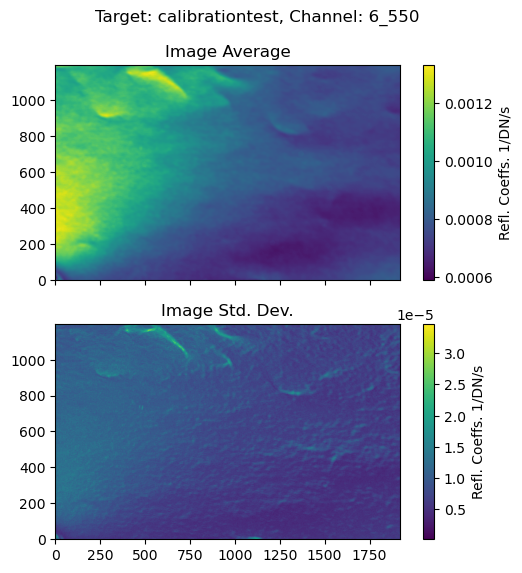

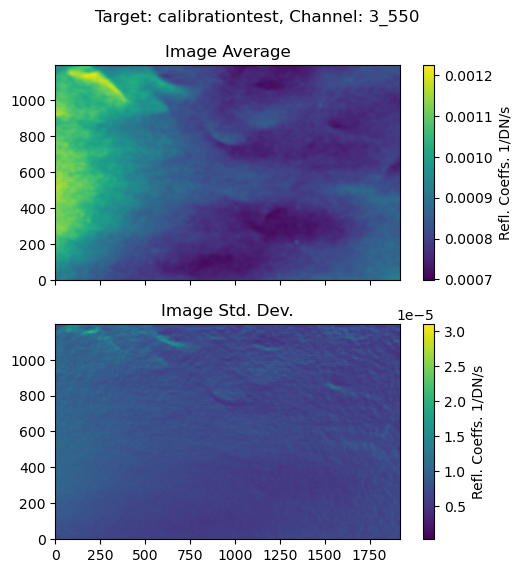

In [6]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

target = 'calibrationtest'
channels = Path('..', 'data', target).glob('*')
cali_coeffs = {} # store the calibration objects in a dictionary
for channel_path in channels:
    channel = os.path.basename(channel_path)
    # load the calibration target images
    cali = LightImage(target, channel)
    cali.image_load()
    # check the mean level

    # load the calibration target dark frames
    dark_cali = DarkImage(target, channel)
    dark_cali.image_load()
    # check the mean level
    
    # subtract the dark frame
    cali.dark_subtract(dark_cali)
    # apply exposure correction
    cali.correct_exposure()
    # compute calibration coefficient image
    cali_coeff = CalibrationImage(cali)
    cali_coeff.compute_reflectance_coefficients()
    cali_coeff.image_display()
    cali_coeffs[channel] = cali_coeff


# Sample Reflectance Calibration
- Load, average and bias correct Sample images
- Correct for exposure
- Apply calibration coefficient frames
- Optional: mask for Calibration Target area and Sample area.
- Save reflectance images

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_5802/886924180.py:27: RuntimeWarning: invalid value encountered in divide
  self.img_std = self.img_ave * np.sqrt((self.img_std/lst_ave)**2 + (cali_source.img_std/cali_source.img_ave)**2)


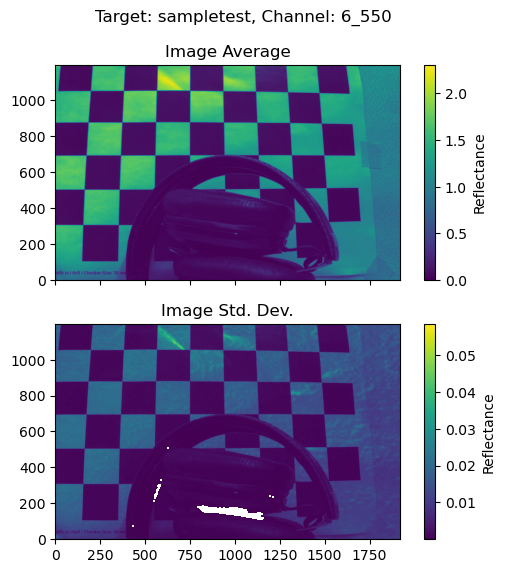

../data/sampletest/6_550
Mean image written to ../data/sampletest/6_550/550_mean_rfl.tif
Error image written to ../data/sampletest/6_550/550_error_rfl.tif


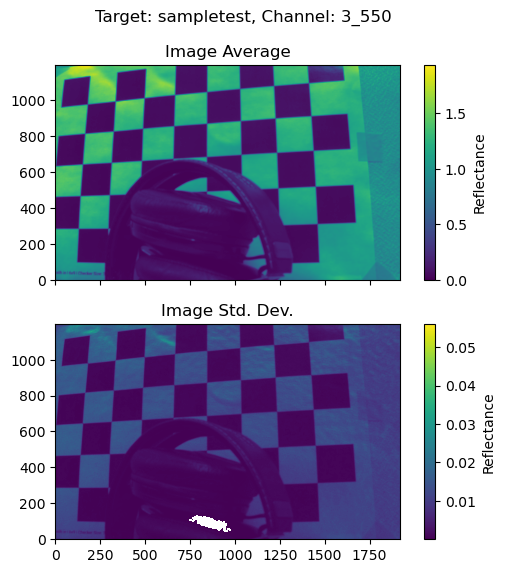

../data/sampletest/3_550
Mean image written to ../data/sampletest/3_550/550_mean_rfl.tif
Error image written to ../data/sampletest/3_550/550_error_rfl.tif


In [7]:
target = 'sampletest'
channels = Path('..', 'data',target).glob('*')
reflectance = {}
for channel_path in channels:
    channel = os.path.basename(channel_path)
    # load the sample images
    smpl = LightImage(target, channel)
    smpl.image_load()
    # load the sample dark frames
    dark_smpl = DarkImage(target, channel)
    dark_smpl.image_load()
    # subtract the dark frame
    smpl.dark_subtract(dark_smpl)
    # apply exposure correction
    smpl.correct_exposure()
    # apply calibration coefficients
    cali_coeff = cali_coeffs[channel]
    refl = ReflectanceImage(smpl)
    refl.calibrate_reflectance(cali_coeff)
    refl.image_display()
    # save the reflectance image
    refl.save_tiff()
    reflectance[channel] = refl
    

# Geometric Alignment
- Load, average and bias correct Geometric images
- Balance images (TBD)
- Extract camera geometric calibration coefficients (TBD)
- Apply image coregistration (TBD)

First we define a new class for storing and processing the geometric calibration images.

In [32]:
import cv2

class GeoCalImage(Image):
    def __init__(self, source_image: LightImage) -> None:
        self.dir = source_image.dir
        # TODO check target directory exists
        self.target = source_image.target
        self.channel = source_image.channel
        self.img_type = 'geo'
        self.camera = source_image.camera
        self.serial = source_image.serial
        self.width = source_image.width
        self.height = source_image.height
        self.cwl = source_image.cwl
        self.fwhm = source_image.fwhm
        self.fnumber = source_image.fnumber
        self.flength = source_image.flength
        self.exposure = source_image.exposure
        self.units = source_image.units
        self.n_imgs = source_image.n_imgs
        self.img_stk = source_image.img_stk
        self.img_ave = source_image.img_ave
        self.img_std = source_image.img_std
        self.chkrrows = 5
        self.chkrcols = 8
        self.chkrsize = 30.0
        self.all_corners = None
        self.object_points = self.define_calibration_points()
        self.corner_points = self.find_corners()
        self.mtx, self.dist, self.rvecs, self.tvecs = None, None, None, None

    def define_calibration_points(self):
        # Define calibration object points and corner locations
        objpoints = np.zeros((self.chkrrows*self.chkrcols, 3), np.float32)
        objpoints[:,:2] = np.mgrid[0:self.chkrrows, 0:self.chkrcols].T.reshape(-1, 2) # what is this??
        objpoints *= self.chkrsize
        return objpoints
    
    def find_corners(self):
        # Find the chessboard corners
        gray = self.img_ave.astype(np.uint8)
        ret, corners = cv2.findChessboardCorners(gray, (self.chkrrows,self.chkrcols), None)
        self.all_corners = ret

        # refine corner locations
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        return corners
    
    def show_corners(self):
        # Draw and display the corners
        gray = self.img_ave.astype(np.uint8)
        img = cv2.drawChessboardCorners(gray, (self.chkrrows,self.chkrcols), self.corner_points, self.all_corners)        
        plt.imshow(img, origin='lower')
        plt.show()

    def calibrate_camera(self):
        # Calibrate the camera
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([self.object_points], [self.corner_points], (self.width, self.height), None, None)
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs
        return mtx, dist, rvecs, tvecs

        

Then we get the geometric calibration coefficients for each camera.

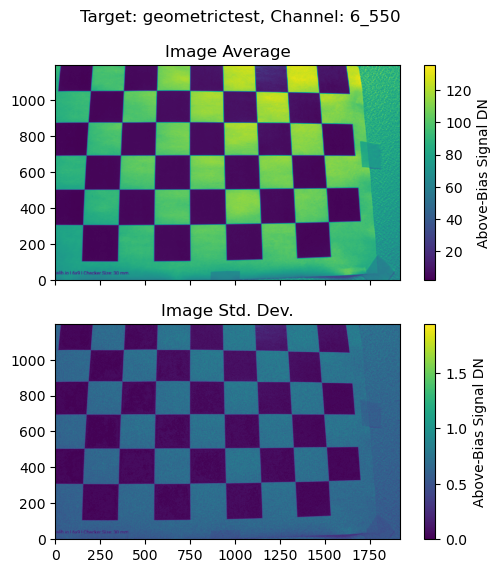

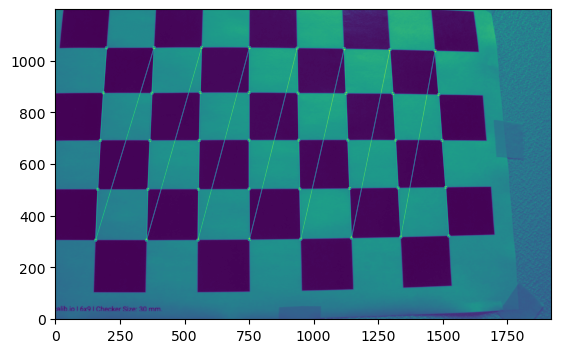

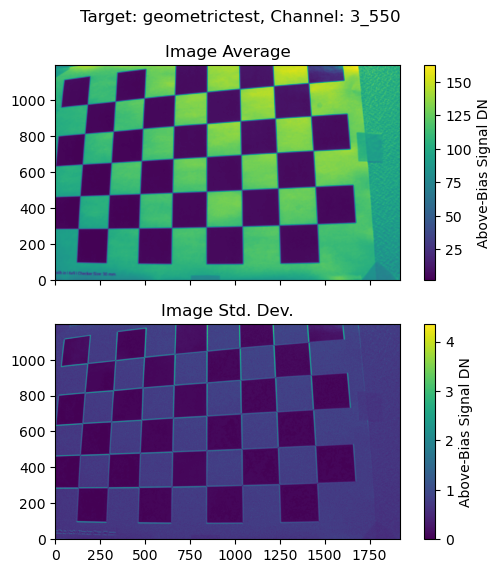

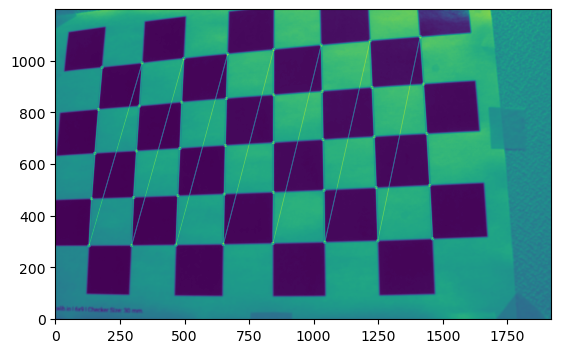

In [33]:
target = 'geometrictest'
channels = Path('..', 'data',target).glob('*')
geocs = {}
for channel_path in channels:
    channel = os.path.basename(channel_path)
    # load the geometric calibration images
    geoc = LightImage(target, channel)
    geoc.image_load()
    # load the geometric calibration dark frames
    dark_geoc = DarkImage(target, channel)
    dark_geoc.image_load()
    # subtract the dark frame
    geoc.dark_subtract(dark_geoc)
    geoc.image_display()
    # # apply image balancing
    geoc = GeoCalImage(geoc)
    geoc.show_corners()
    geoc.calibrate_camera()
    geocs[channel] = geoc



Now we choose a destination image that we will map all other channels too, and we find the stereo calibration and perform co-alignment.

In [34]:
class AlignedImage(Image):
    def __init__(self, source_image: LightImage, source_geocal: GeoCalImage, destination_geocal: GeoCalImage) -> None:
        self.dir = source_image.dir
        # TODO check target directory exists
        self.target = source_image.target
        self.channel = source_image.channel
        self.img_type = 'geo'
        self.camera = source_image.camera
        self.serial = source_image.serial
        self.width = source_image.width
        self.height = source_image.height
        self.cwl = source_image.cwl
        self.fwhm = source_image.fwhm
        self.fnumber = source_image.fnumber
        self.flength = source_image.flength
        self.exposure = source_image.exposure
        self.units = source_image.units
        self.n_imgs = source_image.n_imgs
        self.img_stk = source_image.img_stk
        self.img_ave = source_image.img_ave
        self.img_std = source_image.img_std
        self.source_geocal = source_geocal
        self.destination_geocal = destination_geocal
        self.source_R, self.source_P, self.dest_R, self.dest_P = None, None, None, None    

    def undistort(self):
        # undistort the image
        h, w = self.img_ave.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(self.source_geocal.mtx, self.source_geocal.dist, (w,h), 1, (w,h))
        dst = cv2.undistort(self.img_ave, self.source_geocal.mtx, self.source_geocal.dist, None, newcameramtx)
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]
        self.img_ave = dst
        return dst  

    def stereo_calibrate(self):
        # Stereo calibration
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        # flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        # flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        # flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        ret, mtx1, dist1, mtx2, dist2, R, T, E, F = cv2.stereoCalibrate([self.source_geocal.object_points], [self.source_geocal.corner_points], [self.destination_geocal.corner_points], self.source_geocal.mtx, self.source_geocal.dist, self.destination_geocal.mtx, self.destination_geocal.dist, (self.width, self.height), criteria=criteria, flags=flags)
        # compute rectification parameters
        R1, R2, P1, P2, _, _, _ = cv2.stereoRectify(self.source_geocal.mtx, self.source_geocal.dist, self.destination_geocal.mtx, self.destination_geocal.dist, (self.width, self.height), R, T, alpha=0)
        return R1, P1, R2, P2

    def coalign(self):
        # co-align images
        map1, map2 = cv2.initUndistortRectifyMap(self.source_geocal.mtx, self.source_geocal.dist, self.source_R, self.source_P, (self.width, self.height), cv2.CV_16SC2)
        gray = self.img_ave.astype(np.uint8)
        img_ave = cv2.remap(gray, map1, map2, cv2.INTER_LINEAR)
        return img_ave


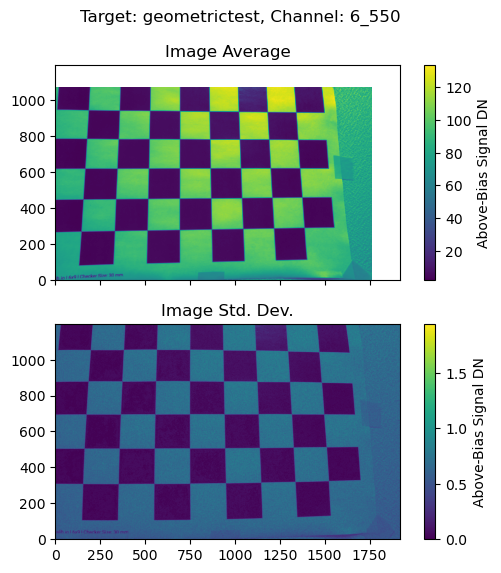

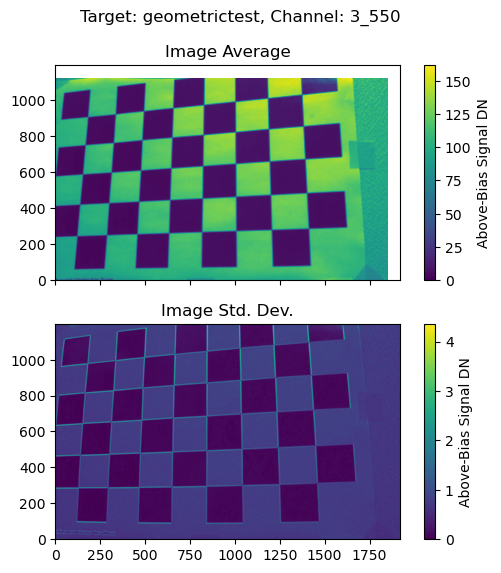

In [36]:
channels = list(reflectance.keys())
destination = channels[0]
dest_geocal = geocs[destination]
for channel in channels:
    source_img = geocs[channel]
    source_geocal = geocs[channel]
    aligned_img = AlignedImage(source_img, source_geocal, dest_geocal)
    aligned_img.image_display()
    aligned_img.undistort()
    aligned_img.image_display()
    # aligned_img.img_ave = aligned_img.coalign()
